This notebook handles exploratory data analysis for the combined dataset.

In [1]:
import os
import time
from tqdm import tqdm

import shapely
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.widgets as pltwidgets

In [2]:
sns.set_theme()
sns.set_style("white")
sns.set_palette("rocket")

In [3]:
path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_Crime_Data_Full.csv"
dataframe = pd.read_csv(path)

In [4]:
dataframe

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,2011/07/01,08:00,FRIDAY,WARRANT,NORTHERN,37.802151,-122.439758
1,2005/10/18,14:30,TUESDAY,DRUG OFFENSE,TENDERLOIN,37.779944,-122.414318
2,2005/01/29,13:45,SATURDAY,VEHICLE MISPLACED,BAYVIEW,37.737576,-122.388799
3,2011/06/02,02:52,THURSDAY,NON-CRIMINAL,CENTRAL,37.803109,-122.414354
4,2003/02/01,08:00,SATURDAY,VEHICLE MISPLACED,BAYVIEW,37.724556,-122.401097
...,...,...,...,...,...,...,...
2364424,2020/08/15,19:05,SATURDAY,ASSAULT,TENDERLOIN,37.785790,-122.412970
2364425,2020/08/15,20:44,SATURDAY,LARCENY THEFT,CENTRAL,37.788808,-122.411886
2364426,2020/08/15,08:00,SATURDAY,NON-CRIMINAL,NORTHERN,37.792263,-122.436204
2364427,2020/08/15,21:52,SATURDAY,RECOVERED VEHICLE,TARAVAL,37.741234,-122.474494


The DataFrame contains the following columns:

* Date: day the incident occured, in YYYY-MM-DD format.
* Time: time the incident occured, in HH:MM miliary time.
* Day of Week: day of week the incident occured.
* Category: the classification of the incident.
* District: the police district where the incident occured.
* Latitude: the latitude of the coordinates where the incident occured.
* Longitude: the longitude of the coordinates where the incident occured.

### Date Analysis

* In this section we explore the distribution of crimes as a function of subsets of the date (i.e. year, month, day).

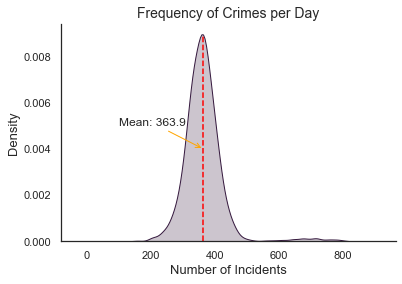

In [5]:
# Create the KDE plot.
date_frequency_data = dataframe.groupby("Date").count().iloc[:, 0]

sns.kdeplot(data=date_frequency_data, shade=True)
plt.axvline(x=date_frequency_data.mean(), ymax=0.95, linestyle="--", color="red")

# Make the plot readable and understandable.
plt.annotate("Mean: " + str(round(date_frequency_data.mean(), 1)), xy=(date_frequency_data.mean(), 0.004), arrowprops={"arrowstyle": "->", "color": "orange"}, xytext=(100, 0.005))
plt.title("Frequency of Crimes per Day", fontdict={"fontsize": 14})
plt.xlabel("Number of Incidents", fontdict={"fontsize": 13})
plt.ylabel("Density", fontdict={"fontsize": 13})
sns.despine()

There is an average of 364 crimes that occur every single day, with a standard deviation of (insert standard deviation here).

Let's explore the distribution of crimes based on the year.

In [6]:
# Determine the distribution of crimes based on the year.
distribution_crime_year = dataframe["Date"].apply(lambda x: x.split("/")[0])
distribution_crime_year = distribution_crime_year.value_counts()
distribution_crime_year.sort_index(inplace=True)

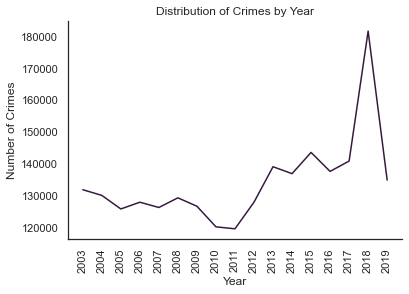

In [7]:
plt.plot(distribution_crime_year.index[:-1], distribution_crime_year.values[:-1])
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel("Year")
_ = plt.ylabel("Number of Crimes")
_ = plt.title("Distribution of Crimes by Year")
sns.despine()

There was a decrease in crime for the years 2008 - 2011 followed by a steady increase until 2019 where there was a sharp drop in the number of crimes. Note that the data for 2020 was removed since the year has not completed at the time of this notebook.

Let's now explore the distribution of crimes based on the month. For this let's try to use a time-varying (based on the year) plot so that we can examine the distribution throughout the years.

In [8]:
# Extract the indices that correspond to each year.
years = [str(year) for year in range(2003, 2020)]
years_indices = {}
years_series = dataframe["Date"].apply(lambda x: x.split("/")[0])
for year in years:
    years_indices[year] = list(years_series[years_series == year].index)

In [9]:
%%script false --no-raise-error
# For each of the years, precompute the number of crimes per month.
years_crime = {}
start_time = time.time()
for year in tqdm(years):
    indices = years_indices[year]
    crimes_per_month = np.zeros(12)
    for index in indices:
        month = int(dataframe.iloc[index]["Date"].split("/")[1]) - 1
        crimes_per_month[month] += 1
    years_crime[year] = crimes_per_month
end_time = time.time()

print("Entire operation took {} seconds.".format(end_time - start_time))

In [10]:
%%script false --no-raise-error
# Save the data because we don't want to compute it again.
import pickle as pkl

path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/distribution_by_year_per_month.pkl"

f = open(path, "wb")
pkl.dump(years_crime, f)
f.close()

The above two cells show how the distribution was pre-computed. The rest of the cells assume that the distribution has already been computed and saved.

In [11]:
# Load the distribution data.
import pickle as pkl

path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/distribution_by_year_per_month.pkl"
distribution_year_month = pkl.load(open(path, "rb"))

Below this are some test cells to create the slider figure.

In [12]:
%matplotlib widget

In [13]:
# Set up the figure.
fig, ax = plt.subplots()

# Extract the data.
year = 2003
data = distribution_year_month[str(year)]
labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Plot the data.
data_plot = plt.bar(labels, data)

# Adjust the plot for readability.
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel("Month")
_ = plt.ylabel("Number of Crimes")
_ = plt.title("Distribution of Crimes by Month")
_ = plt.subplots_adjust(left=0.25, bottom=0.30)

# Create the sliders objects.
axcolor = "white"
slider_axes = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor=axcolor)
year_slider = pltwidgets.Slider(slider_axes, "Year", 2003, 2019, valinit=year, valstep=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
def update(val):
    """Updates the figure based on the slider value.

    Parameters
    ----------
    val : float
        The value returned by the callback from moving the slider.
    
    Returns
    -------
    None

    """
    year = year_slider.val
    heights = distribution_year_month[str(year)]
    for i in range(len(heights)):
        data_plot[i].set_height(heights[i])
    ax.relim()
    ax.autoscale()
    fig.canvas.draw_idle()

In [15]:
# Link the slider to the figure.
year_slider.on_changed(update)

0

Throughout the years the number of crimes is relatively uniform except for 2018, where the amount of crime heavily tips towards the months January to May. This outlier could potentially be explained by the fact that the dataset was constructed by two other datasets, and one of the datasets ended in May 2018 and the other one began potentially later than that. During this period, data could have been lost.

The above claim is also supported by the fact that 2019 saw relatively uniform crime rates across the months.

Let's aggregate the data and rank the months by the number of crimes that occured for that month.

In [16]:
%matplotlib inline

In [17]:
# Extract the number of crimes per month.
conversion_dict = {"January": "01", "February": "02", "March": "03", "April": "04", "May": "05", "June": "06", "July": "07", "August": "08", "September": "09", "October": "10", "November": "11", "December": "12"}
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
months_series = dataframe["Date"].apply(lambda x: x.split("/")[1])

crimes_per_month = np.zeros(12)
start_time = time.time()
for idx, month in tqdm(enumerate(months), total=len(months)):
    crimes_per_month[idx] = len(list(months_series[months_series == conversion_dict[month]].index))
end_time = time.time()

print("\nEntire operation took {} seconds.".format(end_time - start_time))

100%|██████████| 12/12 [00:02<00:00,  4.38it/s]
Entire operation took 2.7642219066619873 seconds.



In [18]:
crimes_per_month

array([212623., 191909., 208672., 200997., 201312., 189392., 199081.,
       204207., 197495., 200432., 180426., 177883.])

In [19]:
# Sort the entries in decreasing order.
sort_key = crimes_per_month.argsort()
crimes_per_month.sort()
crimes_per_month[:] = crimes_per_month[::-1]
months = [months[idx] for idx in sort_key]
months = months[::-1]

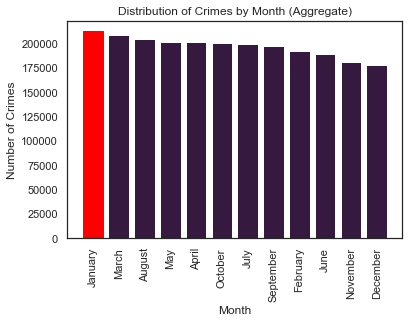

In [20]:
# Plot a bar plot.
bars = plt.bar(months, crimes_per_month)

# Adjust the plot for readability.
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel("Month")
_ = plt.ylabel("Number of Crimes")
_ = plt.title("Distribution of Crimes by Month (Aggregate)")

bars[0].set_color("red")

January appears to be the month that sees the highest crime rates, followed by March and August. The months that see the least amount of crime are in June, November, and December which is close to the holiday season.

Though we would naturally want to see which day (e.g. 1, 2, 3, ..., 30) sees the most crime this is an unfair analysis as there are not a uniform number of days in each month. For example, February only has 28 days while January has 31 days. This would naturally skew the results. 

Instead, we will analyze crimes based on the day of the week (e.g. Monday, Tuesday, ...).

In [21]:
def modify_bar_width(ax, bar_width):
    """Modifies the width of the bars in a seaborn bar plot.

    Parameters
    ----------
    ax : matplotlib.Axes instance
        The Axes on which the new patch widths are set.
    bar_width : float > 0
        The new width of the bars.

    Returns
    -------
    None

    """
    for patch in ax.patches:
        current_width = patch.get_width()
        difference = current_width - bar_width
        patch.set_width(bar_width)
        patch.set_x(patch.get_x() + difference * 0.5)

In [22]:
def plot_percentages_barplot(ax, total):
    """Plots percentages on top of the bars in a seaborn barplot.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot instance
        The Axes used for obtaining the bar height and anchoring text.
    total : float > 0
        The cumulative total of all the values in the barplot, used for computing the percentages.
    
    Returns
    -------
    None

    Notes
    -----
    This method only works for plots created using seaborn.

    """
    for patch in ax.patches:
        height = patch.get_height()
        ax.text(
            patch.get_x() + patch.get_width() / 2., 
            height + 3, "{:2.2f}%".format((height / total) * 100), 
            ha="center",
            va="bottom",
        )

Text(0, 0.5, 'Number of Crimes')

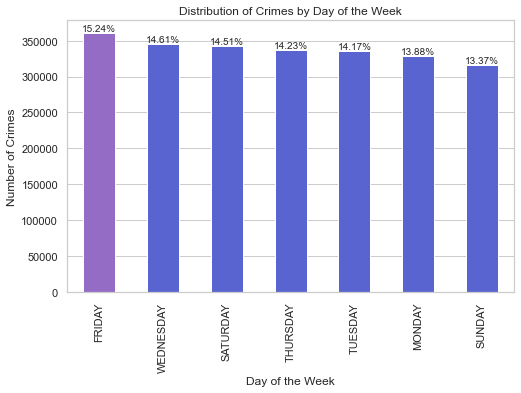

In [23]:
# Compute the number of crimes per day of the week. No need to normalize the data.
crimes_day_of_week = dataframe["Day of Week"].value_counts()
color_palette = ["#4653e4" if (x < max(crimes_day_of_week)) else "#945dd4" for x in crimes_day_of_week]

plt.figure(figsize=(8, 5))
with sns.axes_style("whitegrid"):
    bars = sns.barplot(crimes_day_of_week.index, crimes_day_of_week, palette=color_palette)

# Make the plot visually appealing.
modify_bar_width(bars, 0.5)
plot_percentages_barplot(bars, crimes_day_of_week.sum())

plt.xticks(rotation="vertical")
plt.title("Distribution of Crimes by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Crimes")

From the graphic we see that Friday has the highest crime rate followed by Wednesday and Saturday, whereas Sunday has the lowest crime rate.

### Incident Category Analysis

* In this section we explore the distribution of crime acording to the incident category.

Text(0, 0.5, 'Category')

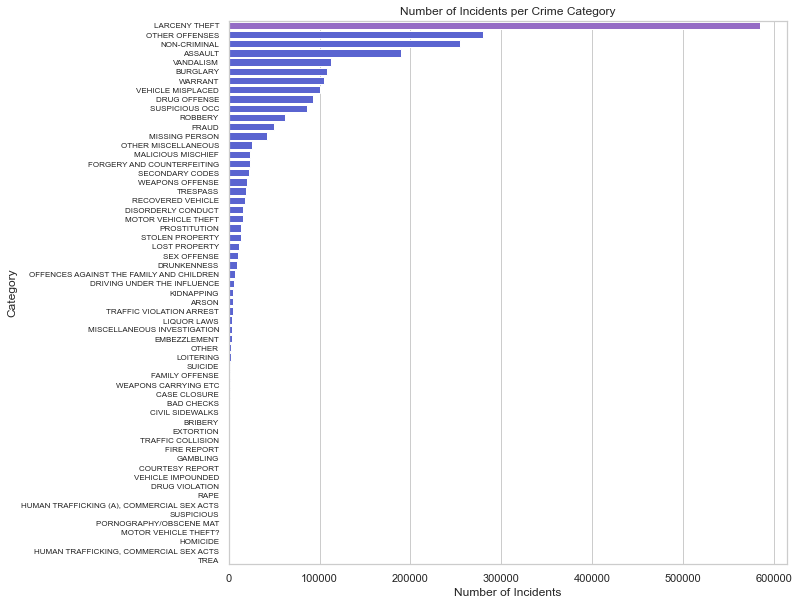

In [24]:
# Group the different offenses.
distribution_crime_category = dataframe["Category"].value_counts()
color_palette = ["#4653e4" if (x < max(distribution_crime_category)) else "#945dd4" for x in distribution_crime_category]

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    bars = sns.barplot(distribution_crime_category, distribution_crime_category.index, orient="h", palette=color_palette)

# Make the plot visually appealing.
bars.tick_params(axis="y", labelsize=8)

plt.title("Number of Incidents per Crime Category")
plt.xlabel("Number of Incidents")
plt.ylabel("Category")

In [25]:
# Compute the percentages for the most prevalent crimes.
percentages_crime_category = (distribution_crime_category / distribution_crime_category.sum()) * 100
percentages_crime_category

LARCENY THEFT                                 24.727704
OTHER OFFENSES                                11.840787
NON-CRIMINAL                                  10.780446
ASSAULT                                        8.006627
VANDALISM                                      4.786610
BURGLARY                                       4.569687
WARRANT                                        4.430541
VEHICLE MISPLACED                              4.243265
DRUG OFFENSE                                   3.903141
SUSPICIOUS OCC                                 3.626161
ROBBERY                                        2.615346
FRAUD                                          2.114337
MISSING PERSON                                 1.808597
OTHER MISCELLANEOUS                            1.094852
MALICIOUS MISCHIEF                             1.011069
FORGERY AND COUNTERFEITING                     0.978799
SECONDARY CODES                                0.945302
WEAPONS OFFENSE                                0

The most prevalent crimes are larceny theft (24.73%), assault (8.01%), vandalism (4.79%), burglary (4.57%) and warrant arrests (4.43%). The second and third most prevalent crimes are either "OTHER OFFENSES" (11.84%) or "NON-CRIMINAL" (10.78%) but they are not descriptive. Additionally "HOMICIDE" is one of the least prevalent crimes clocking in at 0.000677% which is less than 1% of all crimes. Similarly "HUMAN TRAFFICKING, COMMERCIAL SEX ACTS" clocks in at 0.000592% which is also less than 1%. This is somewhat reassuring.

### Police District Analysis

* In this section we analyze the data according to their associated Police District.
* First we create a heatplot representing the density of crime, with respect to the Police District.

We load the centroid information containing the Shapely Polygons representing the Police Districts and their associated centroids.

In [26]:
import gmaps

In [27]:
# API Authentication for Google Maps API.
key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

gmaps.configure(api_key=api_key)

In [28]:
# Load the centroid information
centroids_path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_District_Centroids.csv"
centroids_dataframe = pd.read_csv(centroids_path)

# Convert the Pandas DataFrame to a GeoDataFrame.
centroids_dataframe["geometry"] = centroids_dataframe["geometry"].apply(shapely.wkt.loads)
centroids_dataframe["centroid"] = centroids_dataframe["centroid"].apply(shapely.wkt.loads)
centroids_dataframe = gpd.GeoDataFrame(centroids_dataframe, geometry="geometry")

# Load the Police District polygons.
polygons_dataframe = centroids_dataframe["geometry"]

In [29]:
# Compute the number of police incidents for each of the Police Districts
police_districts = dataframe["Police District"].unique().tolist()
distribution_crime_districts = {}
for district in police_districts:
    distribution_crime_districts[district] = len(dataframe[dataframe["Police District"] == district])

In [30]:
# Normalize the weights.
normalization_factor = sum(distribution_crime_districts.values())
polygon_weights = {key: (distribution_crime_districts[key] / normalization_factor) * 100 for key in distribution_crime_districts.keys()}
maximum_value = max(polygon_weights.values())
polygon_weights = {key: polygon_weights[key] / maximum_value for key in polygon_weights.keys()}
polygon_weights

{'NORTHERN': 0.728370758801262,
 'TENDERLOIN': 0.4859880106945953,
 'BAYVIEW': 0.5426712904025395,
 'CENTRAL': 0.6455550287940666,
 'RICHMOND': 0.3105716217809726,
 'MISSION': 0.7672072523024425,
 'SOUTHERN': 1.0,
 'TARAVAL': 0.41713974928827047,
 'PARK': 0.3126051350421262,
 'INGLESIDE': 0.4799476340253697}

In [31]:
# Prepare the drawing list.
drawing_list = list()
for index, polygon in enumerate(polygons_dataframe):
    police_district = centroids_dataframe.loc[index, "district"]
    drawing_list.append(gmaps.Polygon(polygon.exterior.coords[:], stroke_color="black", stroke_opacity=0.2, fill_color=(255, 0, 0), fill_opacity=polygon_weights[police_district] * 0.5))

In [32]:
fig = gmaps.figure(center=(37.746540, -122.444023), zoom_level=11)
drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)
fig

Figure(layout=FigureLayout(height='420px'))

From the spatial analysis the police districts in the North-East have the highest density of crimes.

Next, it would be a good idea to make a widget that presents a heatmap based on the crime category. Look at modules that would allow us to do this.